In [45]:
### Pulse analysis, spectrum
# Integral, OFL (can move around) , OF -> energy estimators
# OFL_chi2 (pick corresponding chi2) -> 2D plot
# Peak finding and source calibration -> energy linearity
# Baseline noise into energy, energy threshold -> use calibrated peak amplitude. 
# Energy resolution at calibration energy -> fit calibration peak.

# Optimal Filter catergories
# OFO: No delay
# OF: Time delay allowed in full trace (for me this is likely +/- 8k samples, but check)
# OFL: Time delay allowed is set by config.OFL_DELAY setting

In [46]:
import os
# We want to be in the scratch directory.
try:
    if "scratch" not in os.getcwd():
        os.chdir('./scratch')  
except:
    print("Check current directory", os.getcwd())

In [47]:
# Imports
import joblib
import numpy as np
import matplotlib.pyplot as plt
import RQ_helper

In [48]:
# Constants 
#results_fn = "/project/def-zqhong/RicochetData/MIT/MIT_Al_December2022/processed/OFResults_Fe55_20230204.joblib" #_20230111
#output_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_December2022/output/"
#series = "Fe55"

globus_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/"
results_fn = "OFResults_Co60_August.joblib"
output_dir = globus_dir+"output/"
series = "Co60_August"

In [49]:
# Load reduced quantities
RQ_data = joblib.load(globus_dir+"processed/"+results_fn)
exec(RQ_data["config_str"])
#Prepare RQ_helper
rq_helper = RQ_helper.RQ_helper(RQ_data, config, series, output_dir)
#list(RQ_data.keys())

RQ helper is initialised


In [50]:
# Define new fields:

#Time since previous pulse, define for all triggers (not noise traces)
trace_len = config.real_trace_length
trig_loc_tr = RQ_data["trig_loc"]
num_traces_file = max(RQ_data["trig_traceidx"]+1)
trace_loc = RQ_data["trig_traceidx"]
file_loc = RQ_data["trig_fileidx"]
num_files = max(RQ_data["trig_fileidx"]+1)

trig_loc_total = (file_loc*num_traces_file+trace_loc)*trace_len+trig_loc_tr
time_diffs_trig = np.diff(trig_loc_total[RQ_data["trig_ch"]==1])/config.Fs
time_diffs_trig = np.insert(time_diffs_trig, 0, trig_loc_tr[0])
time_diffs_noise = np.diff(trig_loc_total[RQ_data["trig_ch"]==0])/config.Fs
time_diffs_noise = np.insert(time_diffs_noise, 0, trig_loc_tr[0])

RQ_data["time_diff_prev_trig"] = np.empty_like(RQ_data['trig_ch'], dtype=float)
RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"]==1] = time_diffs_trig
RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"]==0] = time_diffs_noise
RQ_data["trig_loc_total"] = trig_loc_total

# Maximum value of the tail, baseline subtracted
RQ_data["MaxTailRel_CH1"] = RQ_data["MaxTail_CH1"]-RQ_data["MeanBase_CH1"] 
RQ_data["TailAmpFraction_CH1"] = RQ_data["MaxTailRel_CH1"]/RQ_data["Amplitude_CH1"]
RQ_data["TailIntFraction_CH1"] = RQ_data["IntegralTail_CH1"]/RQ_data["Integral_CH1"]

In [51]:
list(RQ_data.keys())

['OF0_CH1',
 'OF0_chi2_CH1',
 'OF0_chi2time_CH1',
 'OF0_chi2timeFiltered_CH1',
 'OF0_chi2timeShort_CH1',
 'OF_CH1',
 'OF_chi2_CH1',
 'OF_chi2time_CH1',
 'OF_time_CH1',
 'OFL_CH1',
 'OFL_chi2_CH1',
 'OFL_chi2a_CH1',
 'OFL_chi2b_CH1',
 'OFL_chi2time_CH1',
 'OFL_time_CH1',
 'OFL_chi2timeFiltered_CH1',
 'OFL_chi2timeShort_CH1',
 'OFP1_CH1',
 'OFP2_CH1',
 'OFP1_time_CH1',
 'OFP2_time_CH1',
 'OFP_chi2_CH1',
 'OFP_chi2timeFiltered_CH1',
 'OFP_chi2timeShort_CH1',
 'MeanBase_CH1',
 'MF_CH1',
 'Amplitude_CH1',
 'Max_CH1',
 'MaxHead_CH1',
 'MaxTail_CH1',
 'MaxSlope_CH1',
 'Integral_CH1',
 'Integral2_CH1',
 'IntegralHead_CH1',
 'IntegralTail_CH1',
 'BaselineSlope_CH1',
 'Slope_CH1',
 'PlateauAmplitude_CH1',
 'RiseTime1_CH1',
 'RiseTime2_CH1',
 'RiseTime3_CH1',
 'FallTime1_CH1',
 'FallTime2_CH1',
 'FallTime3_CH1',
 'PulseWidth50_CH1',
 'PulseMaxInd_CH1',
 'OFResolution_CH1',
 'BaselineVariance_CH1',
 'TailVariance_CH1',
 'Max-Min_CH1',
 'Average_CH1',
 'Whole_Trace_Slope_CH1',
 'Skewness_CH1',
 'In

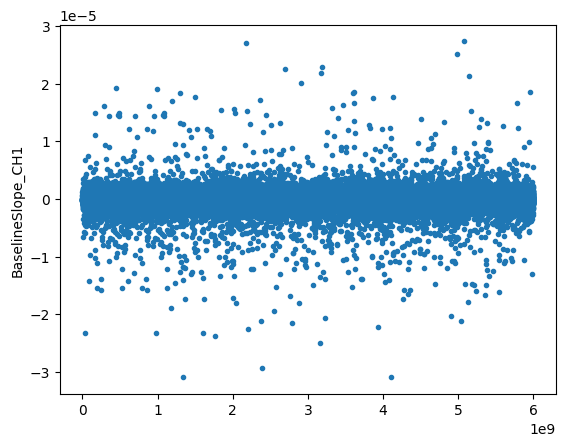

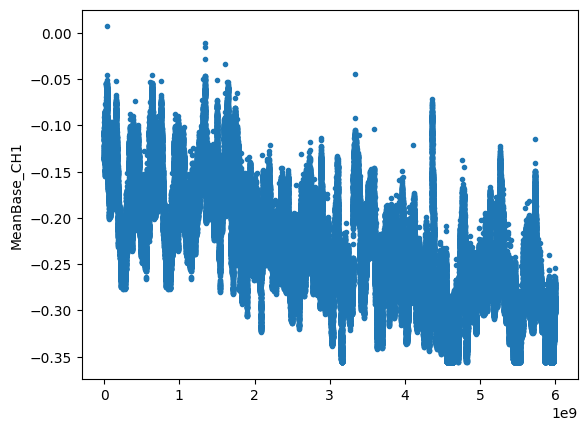

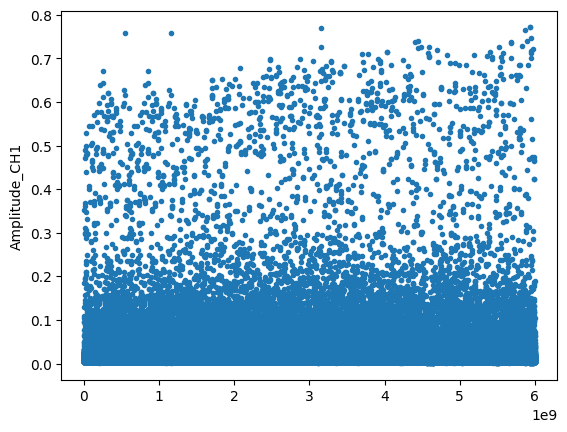

In [52]:
for field in ["BaselineSlope_CH1", "MeanBase_CH1", "Amplitude_CH1"]:
    plt.plot(RQ_data["trig_loc_total"], RQ_data[field], marker='.', lw=0)
    plt.ylabel(field)
    plt.show()

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


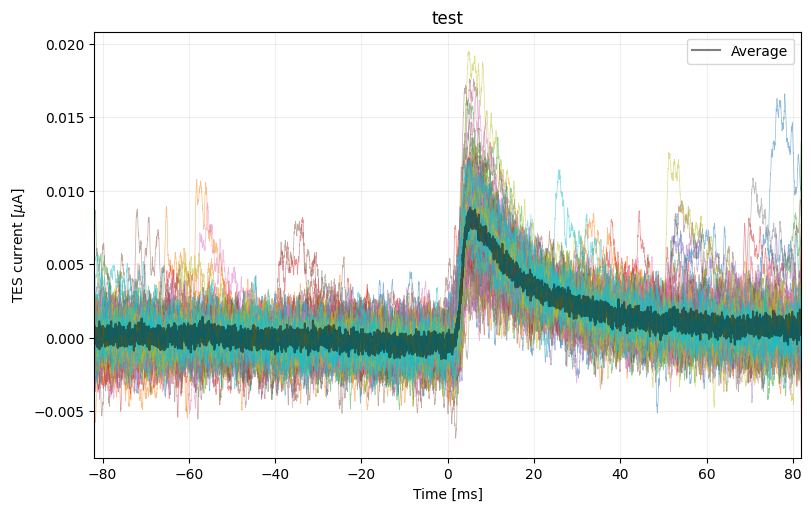

In [53]:
# Co60 Pulses: OFL_chi2_CH1 in [0.95, 1], Integral_CH1 in [15,20]
n_pulses=100
mask = (RQ_data['trig_ch']==1) & (RQ_data["trig_fileidx"]==1) &\
      (RQ_data["OFL_chi2_CH1"]>0.95) & (RQ_data["OFL_chi2_CH1"]<1) &\
      (RQ_data["Integral_CH1"]>15) & (RQ_data["Integral_CH1"]<20)
mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
times, traces_Co60 = rq_helper.plot_traces(mask_sample, "test", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG, post_trig=config.POST_TRIG)

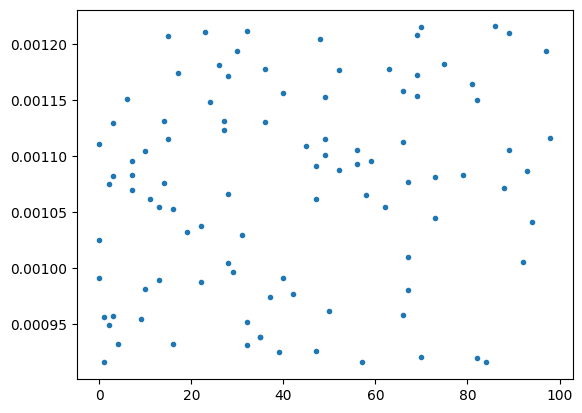

In [54]:
baselines = np.mean(traces_Co60[:,0:config.PRE_TRIG], axis=0)
plt.plot(RQ_data["trig_traceidx"][mask_sample], baselines, lw=0, marker='.')

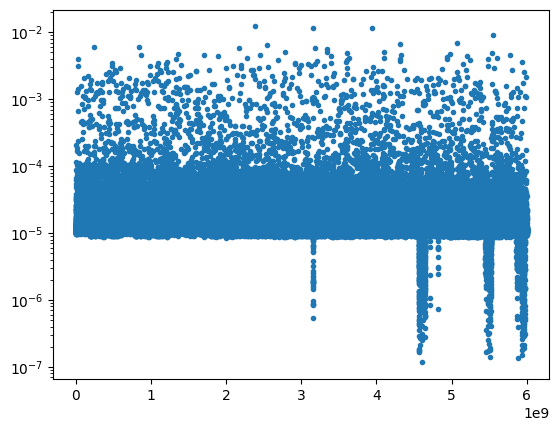

In [55]:
# Look at the baseline variance for stability.
plt.plot(RQ_data["trig_loc_total"], RQ_data['BaselineVariance_CH1'], marker='.', lw=0)
plt.yscale("log")
#plt.ylim(1e-6, 5e-6)

In [56]:
# Quality cuts:
# OFL_time_ between 0,0.005 (5milliseconds)
# Time since last trigger should be at least 0.1s
# The maximum amplitude should be in the first part of the post-trig samples and not in the second.

mask_trig_quality = (RQ_data['trig_ch']==1) &\
                    (RQ_data["TailAmpFraction_CH1"]<0.99) &\
                    (RQ_data["time_diff_prev_trig"]>0.1) &\
                    (RQ_data["TailAmpFraction_CH1"]<0.99) &\
                    (RQ_data['OFL_time_CH1']>0) & (RQ_data['OFL_time_CH1']<0.005)

if "Fe55" in series:
    # Baseline slope needs to be within [-1e7,1e7]
    # BaselineVariance_ < 3.5e-6    -> double peaked! compare with total trig number.
    # Additional weak cut on the trig_amp threshold.
    mask_trig_quality =  mask_trig_quality &\
                        (RQ_data['BaselineVariance_CH1']<3.5e-6) &\
                        (np.abs(RQ_data['BaselineSlope_CH1'])<1e-7) &\
                        (RQ_data["trig_amp"]>1.5)
    
elif "August" in series:
    mask_trig_quality =  mask_trig_quality &\
                         (RQ_data['BaselineVariance_CH1']<2e-5) &\
                         (np.abs(RQ_data['BaselineSlope_CH1'])<4e-7)

In [57]:
# Define Masks
mask_noise = (RQ_data['trig_ch']==0)
mask_tes = (RQ_data['trig_ch']==1) & (RQ_data['Amplitude_CH1']/RQ_data['Integral_CH1']>0.003) & (RQ_data['Amplitude_CH1']>0.02)
mask_crystal = mask_trig_quality & (~mask_tes)
mask_noisy = ~mask_noise & ~mask_trig_quality & ~mask_tes

RQ_data["mask_crystal"] = mask_crystal
RQ_data["mask_tes"] = mask_tes

print('Original triggered events:', sum(RQ_data['trig_ch']))
print('After quality cuts:', sum(mask_trig_quality))
print('TES-like pulses:', sum(mask_tes))
print('Crystal-like pulses', sum(mask_crystal))
trig_amp_threshold = RQ_data['trig_config']['CH1']['trigger_threshold']
print("The auto threshold was tes to", RQ_data['trig_config']['CH1']['trigger_threshold_auto'], "which was calculated to be", trig_amp_threshold)

Original triggered events: 187044
After quality cuts: 122193
TES-like pulses: 1326
Crystal-like pulses 122183
The auto threshold was tes to None which was calculated to be 4


### Explore 1D Data with histograms

In [58]:
trig_mask = RQ_data['trig_ch']
make_hist = False

for k,v in RQ_data.items(): 
    if type(v)==str or type(v)==dict or len(v)!=len(trig_mask):
        print(k,v)
    elif np.issubdtype(v.dtype, np.number):        
        # Make a histogram
        triggered = v[trig_mask==1]
        random = v[trig_mask==0]
        print("Noise:  {:<30}#items:".format(k), random.shape,", mean: {:<10.3g}, std: {:<10.3g}".format(np.mean(random),np.std(random)))
        print("Trigger:{:<30}#items:".format(k), triggered.shape,", mean: {:<10.3g}, std: {:<10.3g}".format(np.mean(triggered),np.std(triggered)))

        if make_hist:
            range_min = max(min(v), np.median(v)-np.std(v))
            range_max = np.percentile(v, 90)
            if all(np.isfinite((range_min,range_max))):
                ranges = (range_min,range_max)
            else:
                renges=None
                
            plt.hist([triggered,random], range=ranges, bins=100, 
                    stacked=False, label=['triggered', 'random'],
                    histtype="stepfilled", alpha=0.6)
            plt.xlabel(k)
            plt.ylabel("# Triggered events")
            plt.legend()
            plt.show()
    else:
        print("error")
        

Noise:  OF0_CH1                       #items: (19910,) , mean: -1.52e-05 , std: 0.00373   
Trigger:OF0_CH1                       #items: (187044,) , mean: 0.0115    , std: 0.0192    
Noise:  OF0_chi2_CH1                  #items: (19910,) , mean: 1.16      , std: 2.22      
Trigger:OF0_chi2_CH1                  #items: (187044,) , mean: 1.36      , std: 3.38      
Noise:  OF0_chi2time_CH1              #items: (19910,) , mean: 2.81      , std: 17.8      
Trigger:OF0_chi2time_CH1              #items: (187044,) , mean: 2.94      , std: 16.1      
Noise:  OF0_chi2timeFiltered_CH1      #items: (19910,) , mean: 1.97      , std: 17.6      
Trigger:OF0_chi2timeFiltered_CH1      #items: (187044,) , mean: 2.05      , std: 15.7      
Noise:  OF0_chi2timeShort_CH1         #items: (19910,) , mean: 0.271     , std: 20.4      
Trigger:OF0_chi2timeShort_CH1         #items: (187044,) , mean: 2.14      , std: 17.9      
Noise:  OF_CH1                        #items: (19910,) , mean: 0.00839   , std: 0.018

### Explore 2D data 

In [59]:
# Define 2D configs
config_2d_scatter = {"type":"scatter"}
config_2d_hist = {"type":"hist"}

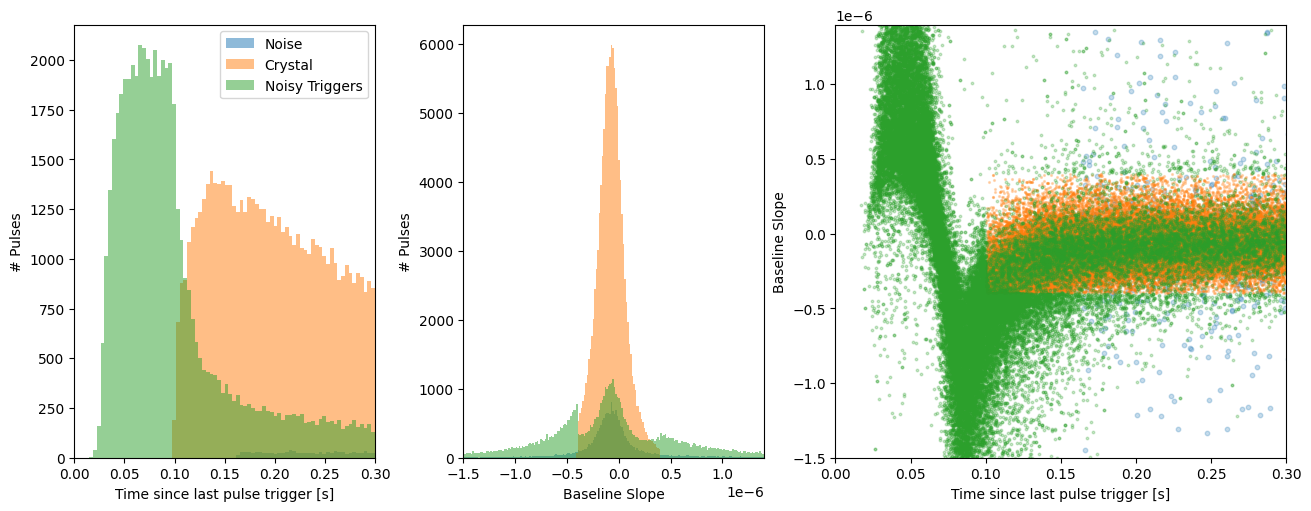

In [60]:
# Investigate pilup pulse cut
var1 = {'name': 'time_diff_prev_trig',
        'label': 'Time since last pulse trigger [s]',
        'range': (0,0.3),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineSlope_CH1',
        'label': 'Baseline Slope',
        'range': (-1.5e-6,1.4e-6),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_noisy] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']
fix,ax = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

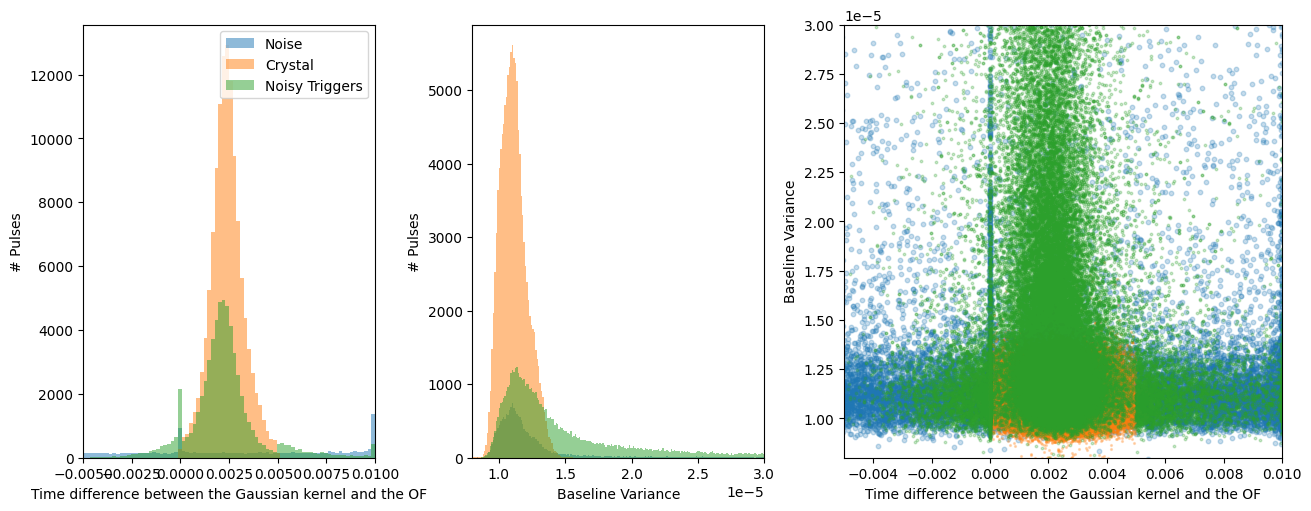

In [61]:
# Investigate pilup pulse cut
var1 = {'name': 'OFL_time_CH1',
        'label': 'Time difference between the Gaussian kernel and the OF',
        'range': (-0.005,0.01),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineVariance_CH1',
        'label': 'Baseline Variance',
        'range': (8e-6,3e-5),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_noisy] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']
fix,ax = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

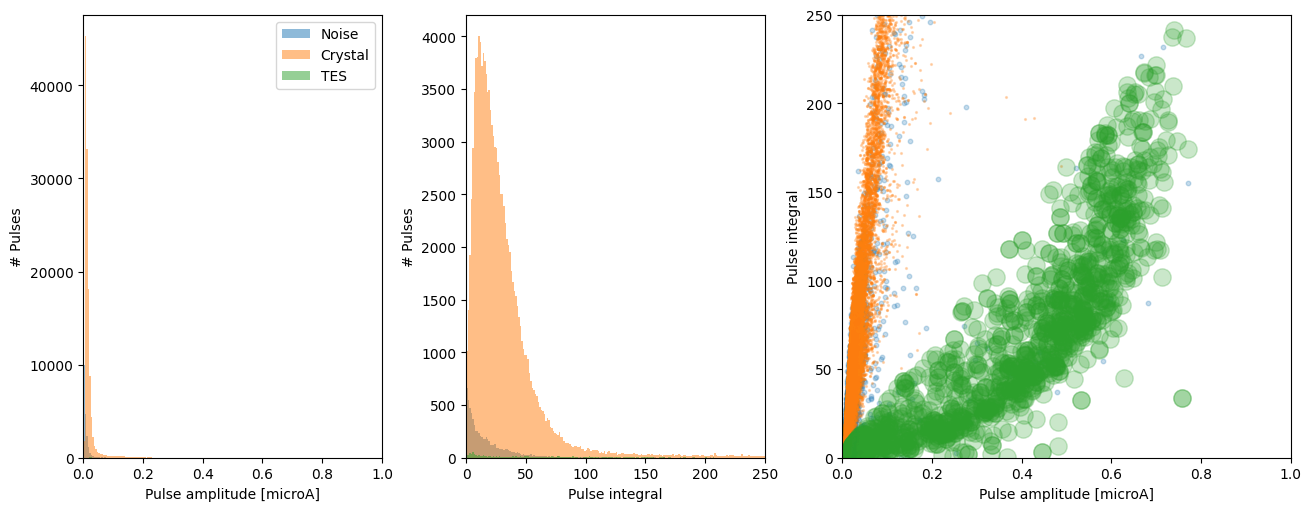

In [62]:
# Zoom out
var1 = {'name': 'Amplitude_CH1',
        'label': 'Pulse amplitude [microA]',
        'range': (0.00,1),
        'bins': 200,
        'norm':False
       }

var2 = {'name': 'Integral_CH1',
        'label': 'Pulse integral',
        'range': (0,250),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

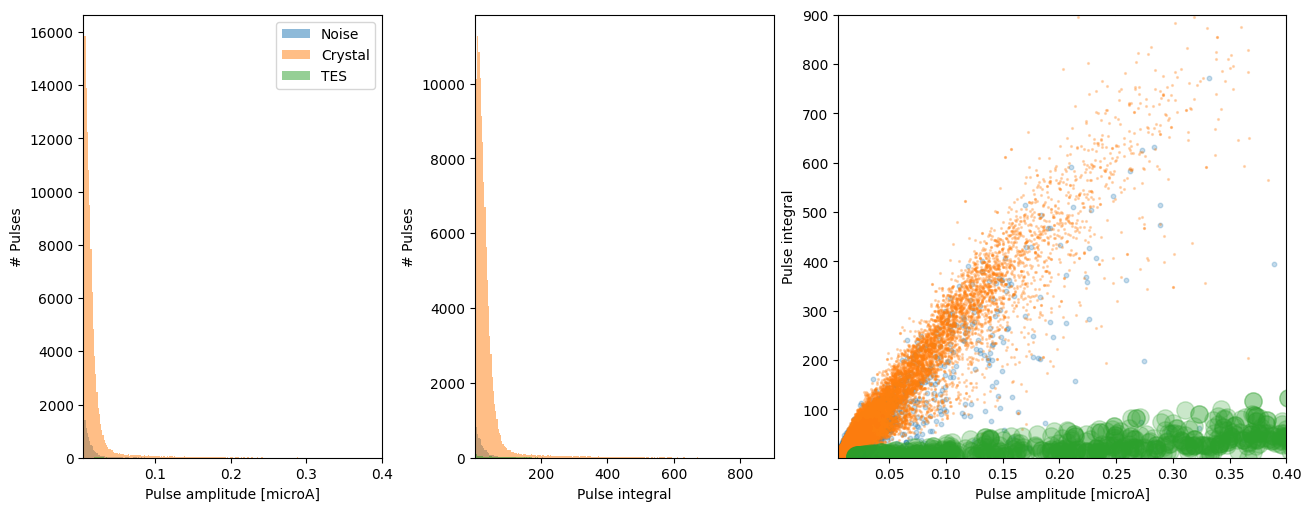

In [63]:
# Zoom in
var1 = {'name': 'Amplitude_CH1',
        'label': 'Pulse amplitude [microA]',
        'range': (0.005,0.4),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'Integral_CH1',
        'label': 'Pulse integral',
        'range': (2,900),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

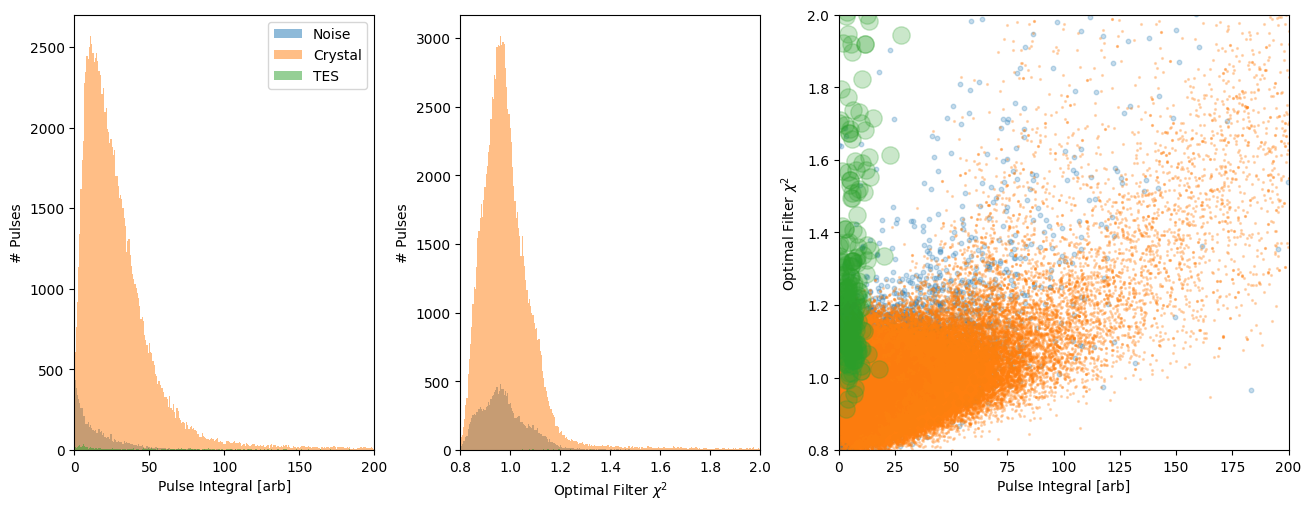

In [64]:
# Chi2
var1 = {'name': 'Integral_CH1',
        'label': 'Pulse Integral [arb]',
        'range': (0,200),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'OF0_chi2_CH1',
        'label': r'Optimal Filter $\chi^2$',
        'range': (0.8,2),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

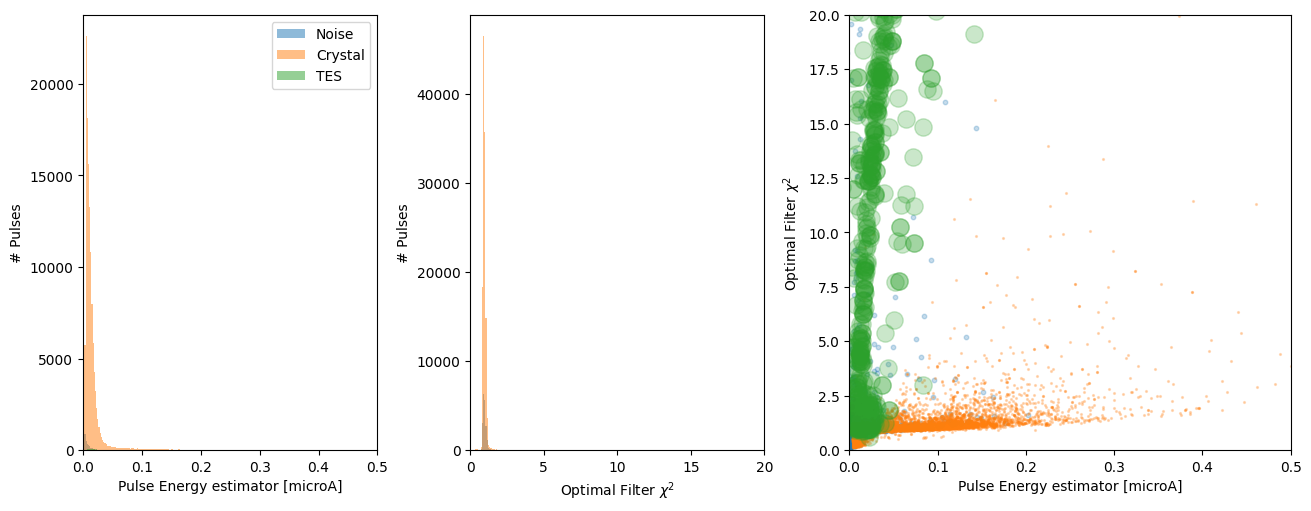

In [65]:
# Chi2
var1 = {'name': 'OFL_CH1',
        'label': 'Pulse Energy estimator [microA]',
        'range': (0.000,0.5),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'OFL_chi2_CH1',
        'label': r'Optimal Filter $\chi^2$',
        'range': (0,20),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

### Optimize filters
- The triggering kernel is a gaussian filter which has some parameters
- The smoothing function is a SavGol filter with a sample length and an order.

In [66]:
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

# Savgol parameters
savgol_nsample = [15, 50, 100, 500]
savgol_order = [3]

# Gaussian trigger parameters
# "Gauss,1,1250,4"
gauss_sigmas = np.arange(200,2000,200)
gauss_truncate = 4
gauss_order = 1

n_traces = 20

# Load some config settings
pretrig = config.PRE_TRIG
posttrig = config.POST_TRIG
WindowForPulseRQs = config.WindowForPulseRQs

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


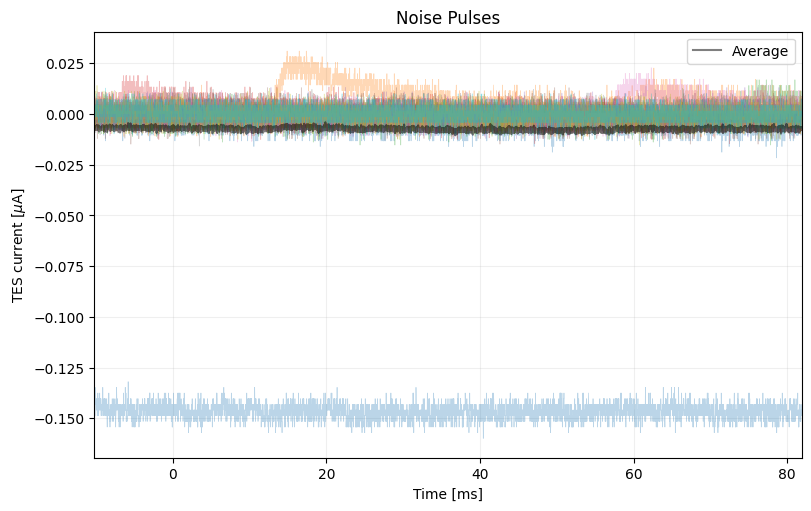

In [67]:
# Load some noise traces:
noise_sample = RQ_helper.sample_from_mask(mask_noise,n_traces)
times, noise_traces = rq_helper.plot_traces(noise_sample, "Noise Pulses", nsmooth=1, plot_data=0.3, plot_mean=0.5)

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


[4.3997955 4.2566404 4.1457834 4.195266  4.2533946 4.232626  4.2622967
 4.216042  4.3296123 4.1082764 4.2932467 4.0885406 4.125049  4.3886385
 4.3734813 4.165976  4.027508  4.386847  4.117562  4.3243113]


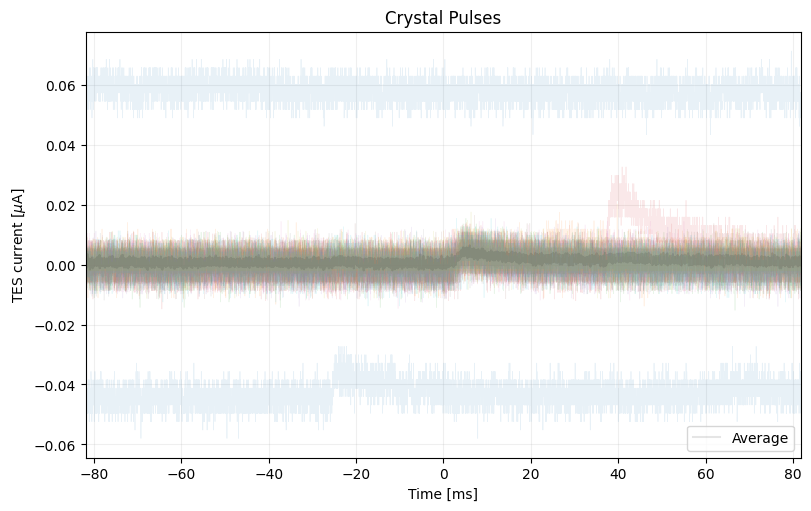

In [68]:
# Load some signal traces with very small trigger amplitude:
crystal_sample = RQ_helper.sample_from_mask(mask_crystal & (RQ_data['trig_amp']<trig_amp_threshold*1.1),n_traces)
times, signal_traces = rq_helper.plot_traces(crystal_sample, "Crystal Pulses", nsmooth=1, plot_data=0.1, plot_mean=0.1, pre_trig=config.PRE_TRIG)
print(RQ_data["trig_amp"][crystal_sample])

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


[ 9.808687   9.3058195  5.350286   7.3793983  4.114036  10.916919
  6.48465   10.598282   8.755691   7.4769444  5.7599487  5.1863227
  7.367064   4.9602203 10.42838    8.150506   5.9673953  6.6640334
  9.9914    10.213651 ]


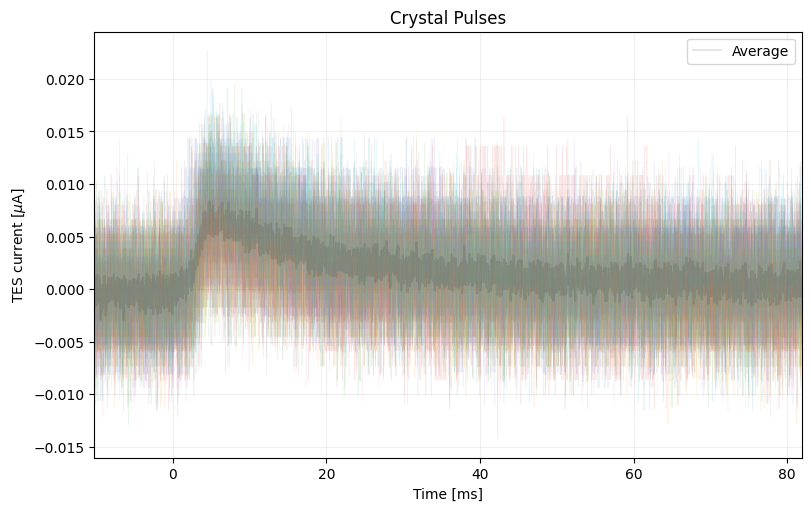

In [69]:
# Load some signal traces with very small OF amplitude:
crystal_sample = RQ_helper.sample_from_mask(mask_crystal & (RQ_data['OFL_CH1']<0.01),n_traces)
times, signal_traces = rq_helper.plot_traces(crystal_sample, "Crystal Pulses", nsmooth=1, plot_data=0.1, plot_mean=0.1)
print(RQ_data["trig_amp"][crystal_sample])

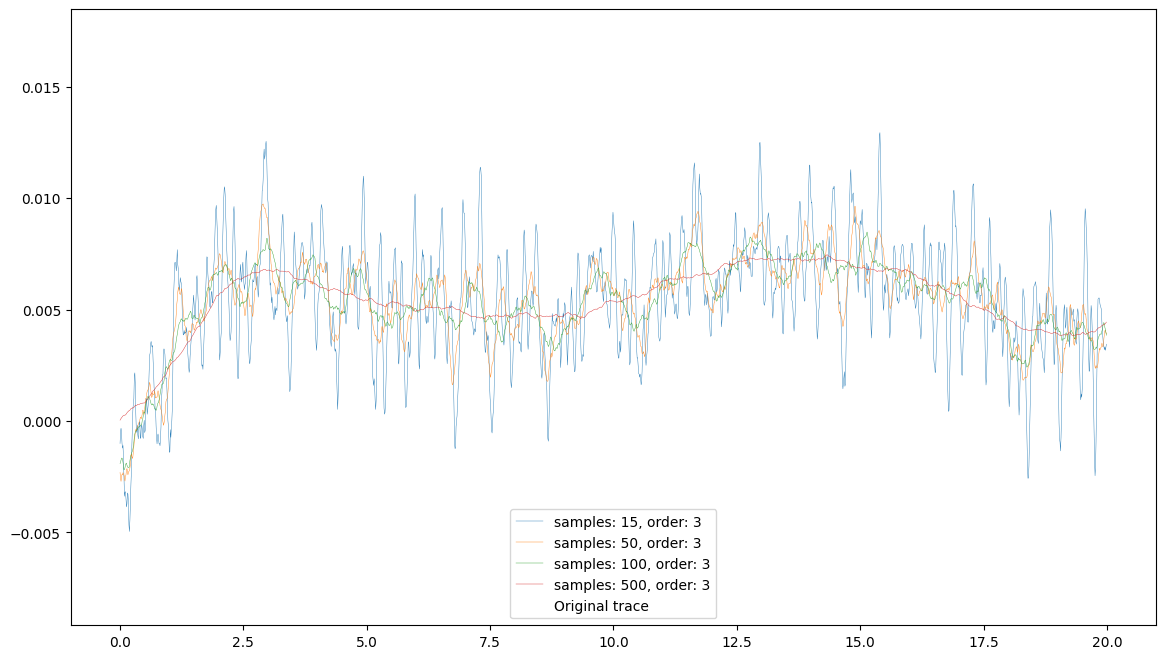

In [70]:
trace = signal_traces.T[0]
sl = np.s_[int(pretrig/8):int(pretrig/8+2*WindowForPulseRQs)]

fig,ax = plt.subplots(figsize=(14,8))
for sg_nsample in savgol_nsample:
    for sg_order in savgol_order:
        filtered_trace = savgol_filter(trace, sg_nsample, sg_order)
        lab = "samples: {}, order: {}".format(sg_nsample,sg_order)
        ax.plot(times[sl], filtered_trace[sl],label=lab, alpha=1, lw=0.3)
        
ax.plot(times[sl], trace[sl], alpha = 0.0, label="Original trace")  
ax.legend()

# From playing around a little, SavGol can be quite large, like 100 is ok! 500 is too large

RiseTime1_ 3 76
RiseTime2_ 11 300
RiseTime3_ 1 12
FallTime1_ 2 148
FallTime2_ 5 379
FallTime3_ 4 24
PulseWidth50_ 21 715
PulseMaxInd_ 917 756


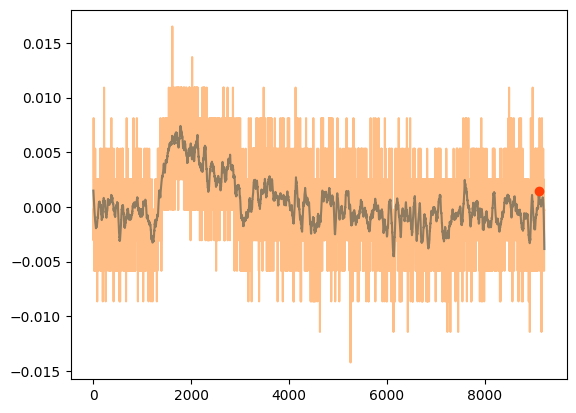

In [71]:
### Investigate Rise and Fall times
# Create a smoothened trace
n_trace = 6
tr_index = np.where(crystal_sample)[0][n_trace]
S = savgol_filter(signal_traces.T[n_trace], 101, 3)

WindowForPulseRQs=1000

# Copied from RQ calculations
tracemax_ind=np.argmax(S[pretrig:pretrig+WindowForPulseRQs])+pretrig
trace_max = np.max(S[pretrig:pretrig+WindowForPulseRQs])

fallingEdge30 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.3)) # This is the falling edge when the pulse drops to 30% of max
fallingEdge50 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.5)) # This is the falling edge when the pulse drops to 50% of max
fallingEdge90 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.9)) # This is the falling edge when the pulse drops to 90% of max

risingEdge30 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.3)) # This is the rising edge when the pulse drops to 30% of max
risingEdge50 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.5)) # This is the rising edge when the pulse drops to 50% of max
risingEdge90 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.9)) # This is the rising edge when the pulse drops to 90% of max

# Printing the results, matched to the PyCRP calculatons. Should be the same?
print("RiseTime1_", risingEdge50-risingEdge30, RQ_data["RiseTime1_CH1"][tr_index])
print("RiseTime2_", risingEdge90-risingEdge50, RQ_data["RiseTime2_CH1"][tr_index])
print("RiseTime3_", tracemax_ind-risingEdge90, RQ_data["RiseTime3_CH1"][tr_index])
print("FallTime1_", fallingEdge30-fallingEdge50, RQ_data["FallTime1_CH1"][tr_index])
print("FallTime2_", fallingEdge50-fallingEdge90, RQ_data["FallTime2_CH1"][tr_index])
print("FallTime3_", -tracemax_ind+fallingEdge90, RQ_data["FallTime3_CH1"][tr_index])
print("PulseWidth50_", (fallingEdge50-risingEdge50), RQ_data["PulseWidth50_CH1"][tr_index])
print("PulseMaxInd_", tracemax_ind-pretrig, RQ_data["PulseMaxInd_CH1"][tr_index])

plt.plot(S)
plt.plot(tracemax_ind, trace_max, marker='o', c='r')
plt.plot(signal_traces.T[n_trace], alpha=0.5)

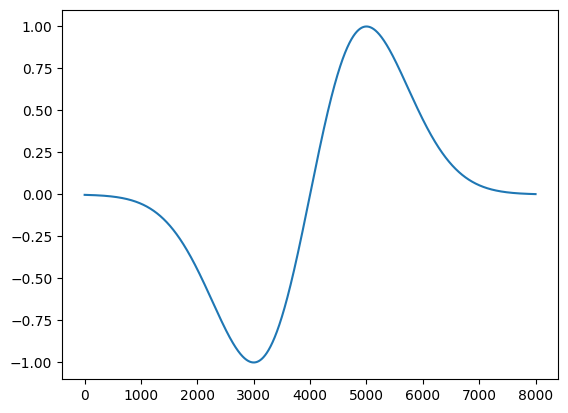

In [72]:
# plot the Gaussian kernel
plt.plot(RQ_data['trig_config']['CH1']['kernel'])

In [73]:
# Gaussian kernel testing
# Found that sigma 1000, order 1, truncate 4 works well
snrs = []
signal_triggers = []
noise_triggers = []

for sigma in tqdm(gauss_sigmas):
    signal = 0
    for signal_tr in signal_traces.T:
        filtered = gaussian_filter(signal_tr, sigma, order=gauss_order, mode='reflect', cval=0.0, truncate=gauss_truncate)
        trig_index = np.argmax(filtered)
        signal_triggers.append(trig_index)
        signal += filtered[trig_index]
        
    noise = 0
    for noise_tr in noise_traces.T:
        filtered = gaussian_filter(noise_tr, sigma, order=gauss_order, mode='reflect', cval=0.0, truncate=gauss_truncate)
        trig_index = np.argmax(filtered)
        noise_triggers.append(trig_index)
        noise += filtered[trig_index]
    snr = signal/noise
    snrs.append(snr)
        
plt.plot(gauss_sigmas,snrs)
plt.grid(alpha=0.5)
plt.show()
plt.hist([signal_triggers, noise_triggers])

NameError: name 'tqdm' is not defined

### Event viewer